## MLP model for prediction of battery electrochemical performance - V8
### Data：20220712
### Author: 
#### - Bin Ma (mabin_wayne@sina.cn)
#### - Lisheng Zhang (sy2113121@buaa.edu.cn)
#### - Siyan Chen (chensiyan1987@jlu.edu.cn)
#### - Xinhua Liu (liuxinhua19@buaa.edu.cn)

### ————Part 1————
#### Necessary packages import

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import preprocessing
import numpy as np
import matplotlib.mlab as mlab
from scipy.stats import norm
import csv
import math
import functools
from bayes_opt import BayesianOptimization
import os, sys
import time
from sklearn.decomposition import PCA

D:\miniconda3\envs\python38_tensorflow25\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### ————Part 2————
#### Data preprocessing

In [2]:
filePath ='./MP_data_down_loading(train+validate).csv'
df = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=',')
print("Original data shape: ", df.shape)


df_charge_space_group_number = df['charge_space_group_number']
df_charge_space_group_number = pd.get_dummies(data = df_charge_space_group_number, prefix = 'charge_space_group_number')
df = df.join(df_charge_space_group_number)

df_discharge_space_group_number = df['discharge_space_group_number']
df_discharge_space_group_number = pd.get_dummies(data = df_discharge_space_group_number, prefix = 'discharge_space_group_number')
df = df.join(df_discharge_space_group_number)


df = df.loc[:,~(df==0).all(axis=0)]


df_working_ion = df['working_ion']
df_num_steps = df['num_steps']
df_stability_charge = df['stability_charge']
df_stability_discharge = df['stability_discharge']
df_charge_crystal_system = df['charge_crystal_system']
df_charge_energy_per_atom = df['charge_energy_per_atom']
df_charge_formation_energy_per_atom = df['charge_formation_energy_per_atom']
df_charge_band_gap = df['charge_band_gap']
df_charge_efermi = df['charge_efermi']
df_discharge_crystal_system = df['discharge_crystal_system']
df_discharge_energy_per_atom = df['discharge_energy_per_atom']
df_discharge_formation_energy_per_atom = df['discharge_formation_energy_per_atom']
df_discharge_band_gap = df['discharge_band_gap']
df_discharge_efermi = df['discharge_efermi']


df = df.drop(['battery_id', 'battery_formula', 'framework_formula', 'adj_pairs', 'capacity_vol', 
              'energy_vol', "formula_charge", "formula_discharge", 'id_charge', 'id_discharge',
              'working_ion', 'num_steps', 'stability_charge', 'stability_discharge', 'charge_crystal_system', 
              'charge_energy_per_atom', 'charge_formation_energy_per_atom', 'charge_band_gap', 'charge_efermi', 'discharge_crystal_system', 
              'discharge_energy_per_atom', 'discharge_formation_energy_per_atom', 'discharge_band_gap', 'discharge_efermi'],
              axis=1)


x_df = df.drop(['average_voltage', 'capacity_grav', 'energy_grav'], axis=1)
y_df = df[ ['average_voltage', 'capacity_grav', 'energy_grav'] ]
print("X data shape of formula part: ", x_df.shape)
print("Y data shape: ", y_df.shape)


pca = PCA(0.99)
pca.fit(x_df)
x_df = pca.transform(x_df)
x_df = pd.DataFrame(x_df)


x_df = x_df.join(df_stability_charge)
x_df = x_df.join(df_charge_energy_per_atom)
x_df = x_df.join(df_charge_formation_energy_per_atom)
x_df = x_df.join(df_charge_band_gap)
x_df = x_df.join(df_charge_efermi)

x_df = x_df.join(df_stability_discharge)
x_df = x_df.join(df_discharge_energy_per_atom)
x_df = x_df.join(df_discharge_formation_energy_per_atom)
x_df = x_df.join(df_discharge_band_gap)
x_df = x_df.join(df_discharge_efermi)


y_max = y_df.max(axis=0)
y_min = y_df.min(axis=0)


min_max_scaler = sklearn.preprocessing.MinMaxScaler()
x_df = min_max_scaler.fit_transform(x_df)
y_df = (y_df - y_min) / (y_max - y_min)
x_df = pd.DataFrame(x_df)


df_working_ion = pd.get_dummies(data = df_working_ion, prefix = 'working_ion')
df_num_steps = pd.get_dummies(data = df_num_steps, prefix = 'num_steps')
df_charge_crystal_system = pd.get_dummies(data = df_charge_crystal_system, prefix = 'charge_crystal_system')
df_discharge_crystal_system = pd.get_dummies(data = df_discharge_crystal_system, prefix = 'discharge_crystal_system')

x_df = x_df.join(df_working_ion)
x_df = x_df.join(df_num_steps)
x_df = x_df.join(df_charge_crystal_system)
x_df = x_df.join(df_discharge_crystal_system)


len_train_test = int(x_df.shape[0]*0.9)
x_train = x_df.iloc[:len_train_test, :]
x_test = x_df.iloc[len_train_test:, :]

y_train = y_df.iloc[:len_train_test]
y_test = y_df.iloc[len_train_test:]

print("X_train shape: ", x_train.shape)
print("Y_train shape: ", y_train.shape)
print("X_validate shape: ", x_test.shape)
print("Y_validate shape: ", y_test.shape)

Original data shape:  (3871, 269)
X data shape of formula part:  (3871, 417)
Y data shape:  (3871, 3)
X_train shape:  (3483, 44)
Y_train shape:  (3483, 3)
X_validate shape:  (388, 44)
Y_validate shape:  (388, 3)





D:\miniconda3\envs\python38_tensorflow25\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
D:\miniconda3\envs\python38_tensorflow25\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


### ————Part 3————
#### Model training

|   iter    |  target   | dropou... | dropou... | dropou... | learni... |  nodes1   |  nodes2   |  nodes3   |
-------------------------------------------------------------------------------------------------------------


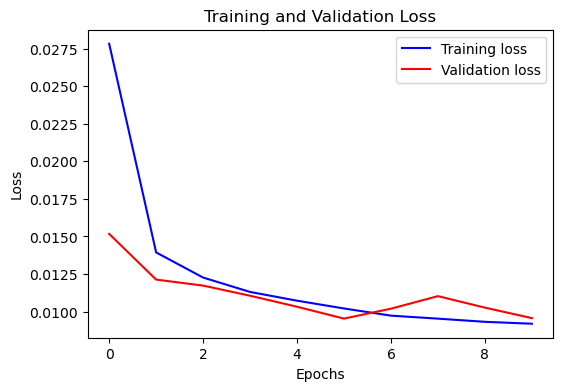

13/13 [==============================] - 0s 2ms/step - loss: 0.0095
|  1        |  104.9    |  0.3996   |  0.8606   |  0.6856   |  0.000602 |  46.69    |  46.69    |  22.4     |


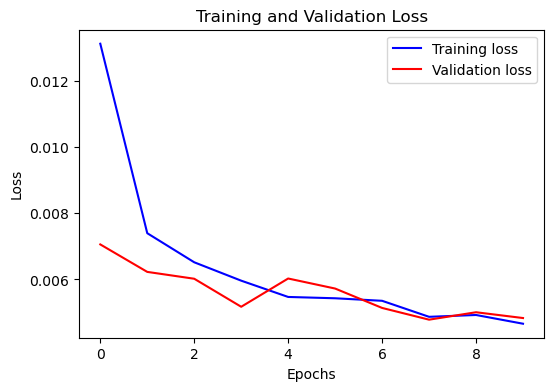

13/13 [==============================] - 0s 2ms/step - loss: 0.0048
|  2        |  208.9    |  0.1749   |  0.4158   |  0.4825   |  0.000675 |  170.2    |  232.8    |  216.0    |


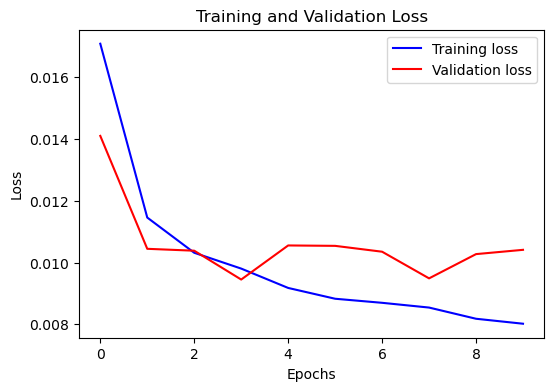

13/13 [==============================] - 0s 2ms/step - loss: 0.0095
|  3        |  105.8    |  0.8362   |  0.3148   |  0.7299   |  0.000586 |  178.0    |  231.6    |  218.3    |
optimizer.max:  {'target': 208.93288508983258, 'params': {'dropout_rate1': 0.17486838539338728, 'dropout_rate2': 0.41579659855442985, 'dropout_rate3': 0.48249200186760033, 'learning_rate': 0.0006753617989921325, 'nodes1': 170.185064996232, 'nodes2': 232.7736454891292, 'nodes3': 215.9909344019063}}


In [3]:
learning_rate = 0.0001
epochs = 1000
nodes1 = 40
nodes2 = 30
nodes3 = 15
dropout_rate1 = 0.2
dropout_rate2 = 0.2
dropout_rate3 = 0.2
inputs_shape = (x_train.shape[1],)

init_points = 10
n_iter = 20


def get_model(inputs_shape, learning_rate, epochs, nodes1, nodes2, nodes3, dropout_rate1, dropout_rate2, dropout_rate3):
    model = keras.Sequential()
    model.add(keras.layers.Dense(nodes1, activation='relu', input_shape=inputs_shape))
    model.add(keras.layers.Dropout(dropout_rate1))
    model.add(keras.layers.Dense(nodes2, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate2))
    model.add(keras.layers.Dense(nodes3, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate3))
    model.add(keras.layers.Dense(3, activation='sigmoid'))
    
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate, momentum=0.9, centered=True), loss='mse')
    #model.summary()
    return model


def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure(figsize=(6,4))
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    #print(loss)


def fit_with(inputs_shape, learning_rate, epochs, nodes1, nodes2, nodes3, dropout_rate1, dropout_rate2, dropout_rate3):
    nodes11 = int(nodes1)*2
    nodes22 = int(nodes2)*2
    nodes33 = int(nodes3)*2
    model = get_model(inputs_shape, learning_rate, epochs, nodes11, nodes22, nodes33, dropout_rate1, dropout_rate2, dropout_rate3)
    callbacks_list = [
        keras.callbacks.ModelCheckpoint(
            filepath='./v8.h5',
            monitor='val_loss',
            save_best_only=True
        )
    ]
    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        validation_data=(x_test,y_test),
        callbacks=callbacks_list,
        verbose=0,
    )
    visualize_loss(history, "Training and Validation Loss")
    best_model = keras.models.load_model('./v8.h5')
    loss = best_model.evaluate(x_test,y_test)
    return(1/loss)


fit_with_partial = functools.partial(fit_with,
                                     inputs_shape = inputs_shape,
                                     epochs = epochs, 
                                     )


pbounds = {'learning_rate': (1e-5, 1e-3), 
           'nodes1': (8, 256), 
           'nodes2': (8, 256),
           'nodes3': (8, 256),
           'dropout_rate1': (0.1, 0.9),
           'dropout_rate2': (0.1, 0.9),
           'dropout_rate3': (0.1, 0.9)
           }
optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(init_points=init_points, n_iter=n_iter,)
print('optimizer.max: ', optimizer.max)

### ————Part 4————
#### Prediction and result storage

Caculation times:  0


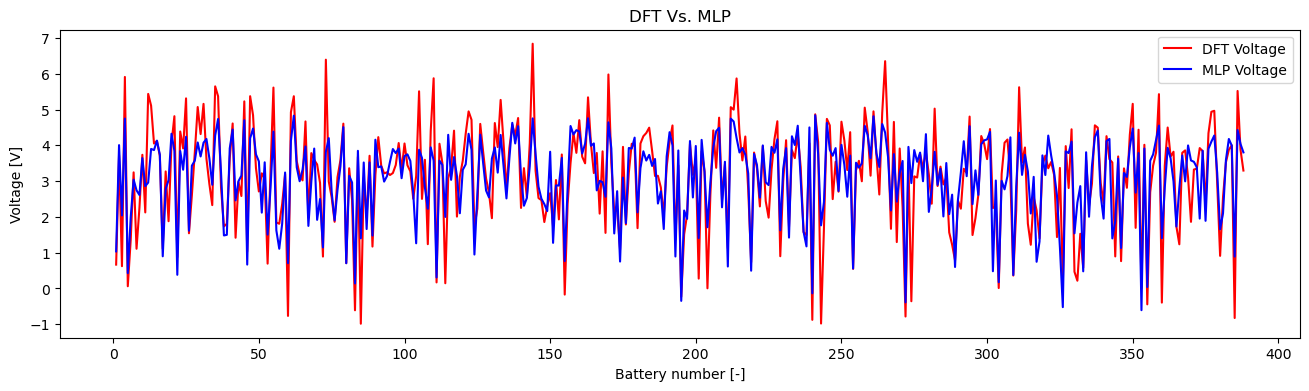

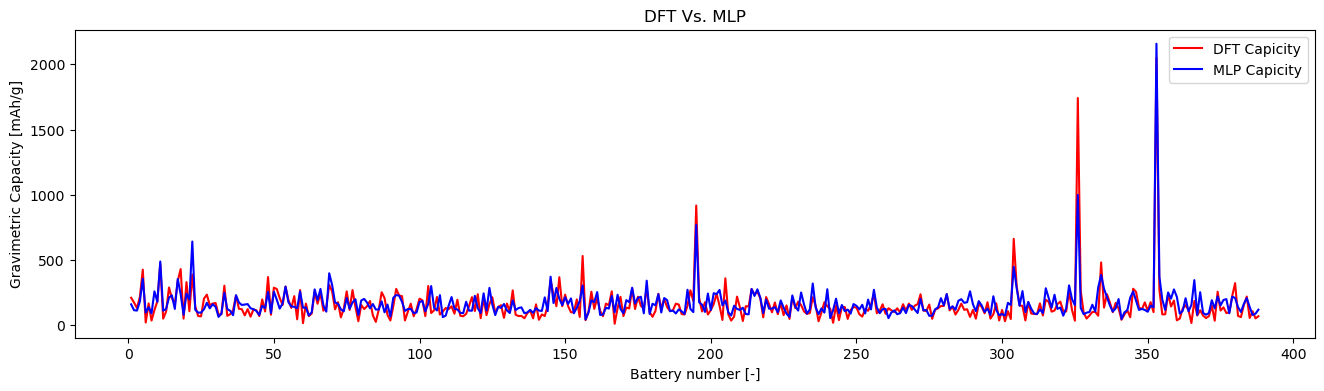

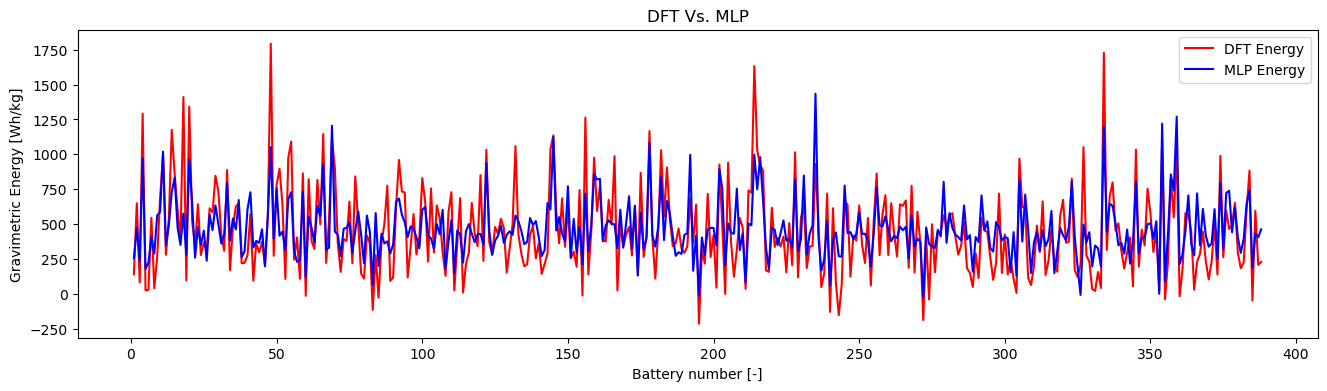

Caculation times:  1


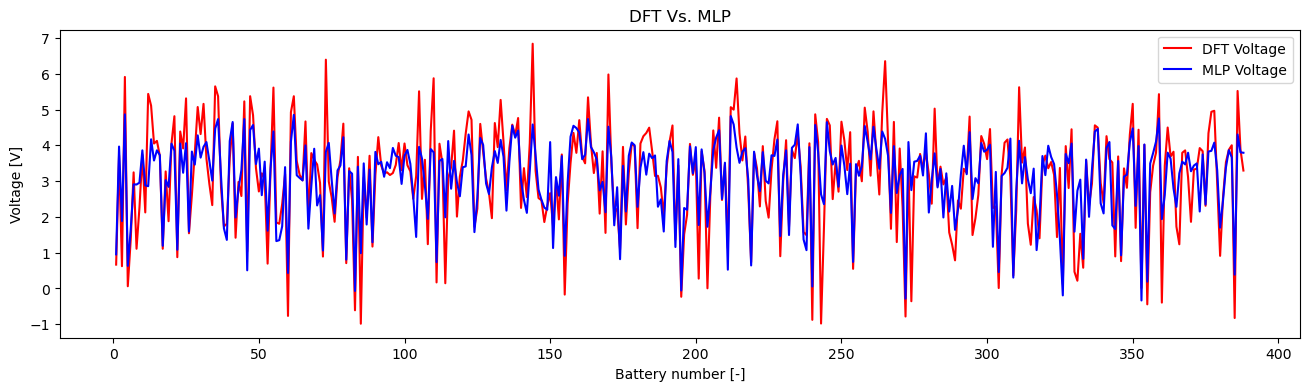

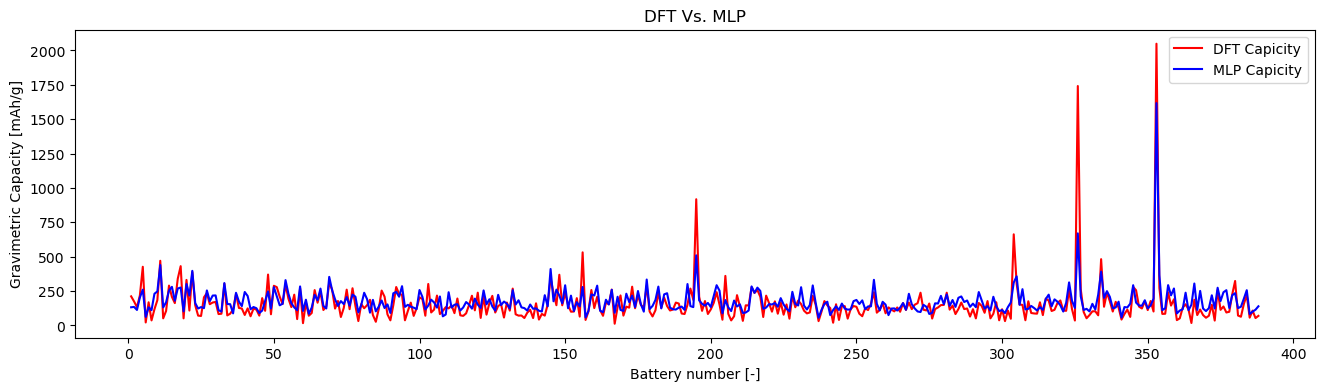

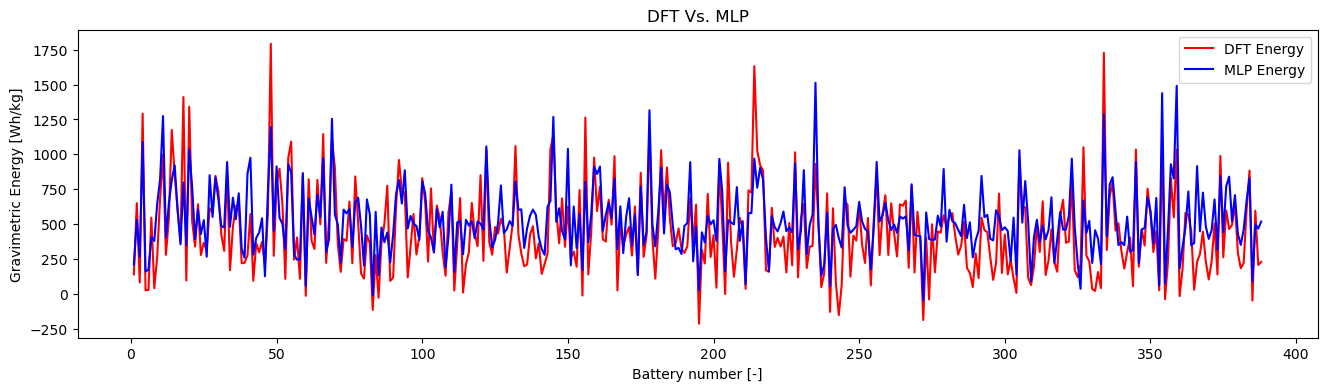




V Rmse:  [0.7921552765167905, 0.7814389731204421]
C Rmse:  [77.20979636203549, 90.57334685767411]
E Rmse:  [199.9262070728721, 206.76892821571897]
Averange Rmse:  [26.264702305023025, 30.712074934638334]


rmse_idx_V:  1
rmse_min_V:  0.7814389731204421
rmse_idx_C:  0
rmse_min_C:  77.20979636203549
rmse_idx_E:  0
rmse_min_E:  199.9262070728721
rmse_idx:  0
rmse_min:  26.264702305023025


In [4]:
Rmses_V = []
Rmses_C = []
Rmses_E = []
Rmses = []

times = 50
epochs = 1000


for i in range(0, times):
    print("Caculation times: ", i)

    def fit_with_for_train(inputs_shape, learning_rate, epochs, nodes1, nodes2, nodes3, dropout_rate1, dropout_rate2, dropout_rate3):
        nodes11 = int(nodes1)*2
        nodes22 = int(nodes2)*2
        nodes33 = int(nodes3)*2
        model = get_model(inputs_shape, learning_rate, epochs, nodes11, nodes22, nodes33, dropout_rate1, dropout_rate2, dropout_rate3)
        callbacks_list = [
            keras.callbacks.ModelCheckpoint(
                filepath='./v8-%i.h5'%i,
                monitor='val_loss',
                save_best_only=True
            )
        ]
        history = model.fit(
            x_train,
            y_train,
            epochs=epochs,
            validation_data=(x_test,y_test),
            callbacks=callbacks_list,
            verbose=0,
        )
        #visualize_loss(history, "Training and Validation Loss")
        best_model = keras.models.load_model('./v8-%i.h5'%i)
        return(best_model)
    
    
    model = fit_with_for_train(inputs_shape = inputs_shape, 
                               epochs = epochs, 
                               #learning_rate = learning_rate,
                               learning_rate = optimizer.max['params']['learning_rate'], 
                               #nodes1 = nodes1, 
                               nodes1 = optimizer.max['params']['nodes1'],
                               #nodes2 = nodes2,
                               nodes2 = optimizer.max['params']['nodes2'],
                               #nodes3 = nodes3,
                               nodes3 = optimizer.max['params']['nodes3'],
                               #dropout_rate1 = dropout_rate1,
                               dropout_rate1 = optimizer.max['params']['dropout_rate1'],
                               #dropout_rate2 = dropout_rate2,
                               dropout_rate2 = optimizer.max['params']['dropout_rate2'],
                               #dropout_rate3 = dropout_rate3,
                               dropout_rate3 = optimizer.max['params']['dropout_rate3']
                              )
    
    
    y_pred = model.predict(x_test)
    y_pred_average_voltage = y_pred[:, 0]
    y_pred_capacity_grav = y_pred[:, 1]
    y_pred_energy_grav = y_pred[:, 2]

    y_pred_average_voltage = y_pred_average_voltage*(y_max[0] - y_min[0]) + y_min[0]
    y_pred_capacity_grav = y_pred_capacity_grav*(y_max[1] - y_min[1]) + y_min[1]
    y_pred_energy_grav = y_pred_energy_grav*(y_max[2] - y_min[2]) + y_min[2]

    y_test_average_voltage = y_test.iloc[:, 0]
    y_test_capacity_grav = y_test.iloc[:, 1]
    y_test_energy_grav = y_test.iloc[:, 2]
    y_test_average_voltage = y_test_average_voltage*(y_max[0] - y_min[0]) + y_min[0]
    y_test_capacity_grav = y_test_capacity_grav*(y_max[1] - y_min[1]) + y_min[1]
    y_test_energy_grav = y_test_energy_grav*(y_max[2] - y_min[2]) + y_min[2]


    filename = 'results_out/%i predicted_results.csv'%i
    headers=['battery_number', 'average_voltage', 'predicted_average_voltage', 'capacity_grav',
            'predicted_capacity_grav', 'energy_grav', 'predicted_energy_grav', 
             'working_ion_Al', 'working_ion_Ca', 'working_ion_Cs', 'working_ion_K', 
             'working_ion_Li', 'working_ion_Mg', 'working_ion_Na', 'working_ion_Rb',
             'working_ion_Y', 'working_ion_Zn']

    with open(filename,'w',newline ='') as f:
        fcsv = csv.writer(f)
        fcsv.writerow(headers)

    for i in range(len(y_pred)):
        rows = [i+1, y_test_average_voltage.iloc[i], y_pred_average_voltage[i], 
                y_test_capacity_grav.iloc[i], y_pred_capacity_grav[i],
                y_test_energy_grav.iloc[i], y_pred_energy_grav[i],
                x_test.iloc[i, 14], x_test.iloc[i, 15], x_test.iloc[i, 16], 
                x_test.iloc[i, 17], x_test.iloc[i, 18], x_test.iloc[i, 19], 
                x_test.iloc[i, 20], x_test.iloc[i, 21],x_test.iloc[i, 22], x_test.iloc[i, 23]
               ]
        with open(filename,'a',newline ='') as f:
            fcsv = csv.writer(f)
            fcsv.writerow(rows)


    battery_number = range(1,len(y_pred_average_voltage)+1)

    plt.figure(figsize=(16,4))
    plt.plot(battery_number, y_test_average_voltage, "r", label="DFT Voltage")
    plt.plot(battery_number, y_pred_average_voltage, "b", label="MLP Voltage")
    plt.title('DFT Vs. MLP')
    plt.xlabel("Battery number [-]")
    plt.ylabel("Voltage [V]")
    plt.legend()

    plt.figure(figsize=(16,4))
    plt.plot(battery_number, y_test_capacity_grav, "r", label="DFT Capicity")
    plt.plot(battery_number, y_pred_capacity_grav, "b", label="MLP Capicity")
    plt.title('DFT Vs. MLP')
    plt.xlabel("Battery number [-]")
    plt.ylabel("Gravimetric Capacity [mAh/g]")
    plt.legend()

    plt.figure(figsize=(16,4))
    plt.plot(battery_number, y_test_energy_grav, "r", label="DFT Energy")
    plt.plot(battery_number, y_pred_energy_grav, "b", label="MLP Energy")
    plt.title('DFT Vs. MLP')
    plt.xlabel("Battery number [-]")
    plt.ylabel("Gravimetric Energy [Wh/kg]")
    plt.legend()

    plt.show()


    def get_mse(records_real, records_predict):
        if len(records_real) == len(records_predict):
            return sum([(x - y) ** 2 for x, y in zip(records_real, records_predict)]) / len(records_real)
        else:
            return None

    def get_rmse(records_real, records_predict):
        mse = get_mse(records_real, records_predict)
        if mse:
            return math.sqrt(mse)
        else:
            return None

    with open(filename) as f:
        reader = csv.reader(f)
        header_row = next(reader)
        reals = []
        predicts = []
        for row in reader:
            real = float(row[1])
            reals.append(real)
            predict = float(row[2])
            predicts.append(predict)
    length = len(reals)
    Rmse_V = get_rmse(reals,predicts)
    #print("Rmse of average_voltage: ", Rmse_V)
    Rmses_V.append(Rmse_V)

    with open(filename) as f:
        reader = csv.reader(f)
        header_row = next(reader)
        reals = []
        predicts = []
        for row in reader:
            real = float(row[3])
            reals.append(real)
            predict = float(row[4])
            predicts.append(predict)
    length = len(reals)
    Rmse_C = get_rmse(reals,predicts)
    #print("Rmse of capacity_grav: ", Rmse_C)
    Rmses_C.append(Rmse_C)

    with open(filename) as f:
        reader = csv.reader(f)
        header_row = next(reader)
        reals = []
        predicts = []
        for row in reader:
            real = float(row[5])
            reals.append(real)
            predict = float(row[6])
            predicts.append(predict)
    length = len(reals)
    Rmse_E = get_rmse(reals,predicts)
    #print("Rmse of energy_grav: ", Rmse_E)
    Rmses_E.append(Rmse_E)


    Rmse = (Rmse_V + Rmse_C + Rmse_V) / 3
    #print("Rmse: ", Rmse)
    Rmses.append(Rmse)
    
print("\n\n")
print("V Rmse: ", Rmses_V)
print("C Rmse: ", Rmses_C)
print("E Rmse: ", Rmses_E)
print("Averange Rmse: ", Rmses)
print("\n")
rmse_idx_V = np.argmin(Rmses_V)
rmse_min_V = np.amin(Rmses_V)
rmse_idx_C = np.argmin(Rmses_C)
rmse_min_C = np.amin(Rmses_C)
rmse_idx_E = np.argmin(Rmses_E)
rmse_min_E = np.amin(Rmses_E)
rmse_idx = np.argmin(Rmses)
rmse_min = np.amin(Rmses)
print("rmse_idx_V: ", rmse_idx_V)
print("rmse_min_V: ", rmse_min_V)
print("rmse_idx_C: ", rmse_idx_C)
print("rmse_min_C: ", rmse_min_C)
print("rmse_idx_E: ", rmse_idx_E)
print("rmse_min_E: ", rmse_min_E)
print("rmse_idx: ", rmse_idx)
print("rmse_min: ", rmse_min)


filename2 = 'results_out/rmse & time.csv'
headers=['rmse_idx_V', 'rmse_min_V', 'rmse_idx_C', 'rmse_min_C', 'rmse_idx_E', 'rmse_min_E', 'rmse_idx', 'rmse_min', 'optimizer.max']
with open(filename2,'w',newline ='') as f:
    fcsv = csv.writer(f)
    fcsv.writerow(headers)
rows = [rmse_idx_V, rmse_min_V, rmse_idx_C, rmse_min_C, rmse_idx_E, rmse_min_E, rmse_idx, rmse_min,optimizer.max]
with open(filename2,'a',newline ='') as f:
    fcsv = csv.writer(f)
    fcsv.writerow(rows)